In [336]:
import pandas as pd
import random
import math
import pycountry
import pypopulation
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import geopandas as gpd
from descartes import PolygonPatch

In [337]:
csv = pd.read_csv('data(1).csv')
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax2 = world.plot( figsize=(8,4), edgecolor=u'gray', cmap='Set2' )

# def plotCountryPatch( axes, country_name, fcolor ):
#     # plot a country on the provided axes
#     nami = world[world.name == country_name]
#     namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
#     namig0 = {'type': namigm[0]['geometry']['type'], \
#               'coordinates': namigm[0]['geometry']['coordinates']}
#     axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2 ))



In [338]:
# coalesce multiple entries of a single country 
df = csv.groupby(['Country_Region'])[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# drop unneeded fields 
df = df[["Country_Region", "Confirmed", "Deaths", "Recovered"]]

In [339]:
df_scaled = df.copy()
# df_scaled['Confirmed'].plot(kind = 'bar')


population = []
to_drop = []
# print(len(df_scaled.index))
for index, row in df_scaled.iterrows():
    # print(row['Country_Region'])
    if pycountry.countries.get(name=row['Country_Region']) != None:
        population.append(pypopulation.get_population_a3(pycountry.countries.get(name=row['Country_Region']).alpha_3))
        # print(index, row['Country_Region'])
        # print(pycountry.countries.get(name=row['Country_Region']).alpha_3)
        # print(pycountry.countries.lookup("Russian Federation"))
    else:
        to_drop.append(index)

df_scaled = df_scaled.drop(to_drop)
df_scaled['Population'] = population
# print(to_drop)
# print(len(df_scaled.index))

# print(df_scaled)

df_scaled['Confirmed'] = (df_scaled['Confirmed']) / (df_scaled['Population'])
df_scaled['Deaths'] = (df_scaled['Deaths']) / (df_scaled['Population'])
df_scaled['Recovered'] = (df_scaled['Recovered']) / (df_scaled['Population'])

df_scaled = df_scaled[["Country_Region", "Confirmed", "Deaths", "Recovered"]]
# print(df_scaled)

df_scaled['Confirmed'] = (df_scaled['Confirmed'] - df_scaled['Confirmed'].min()) / (df_scaled['Confirmed'].max() - df_scaled['Confirmed'].min())
df_scaled['Deaths'] = (df_scaled['Deaths'] - df_scaled['Deaths'].min()) / (df_scaled['Deaths'].max() - df_scaled['Deaths'].min())
df_scaled['Recovered'] = (df_scaled['Recovered'] - df_scaled['Recovered'].min()) / (df_scaled['Recovered'].max() - df_scaled['Recovered'].min())

# df_scaled['Confirmed'] = (df_scaled['Confirmed']) / (df_scaled['Confirmed'].max())
# df_scaled['Deaths'] = (df_scaled['Deaths']) / (df_scaled['Deaths'].max())
# df_scaled['Recovered'] = (df_scaled['Recovered']) / (df_scaled['Recovered'].max())

In [340]:
som_dim = (10, 10) # x, y dimensions
learning_rate = 0.01
iterations = 10000

radius = max(som_dim) // 2
data_dimensions = df_scaled.shape[1] - 1 #remove index from shape
time_const = iterations / math.log(radius)

neurons = [[] for _ in range(som_dim[0])]

for row in range(som_dim[0]):
    for col in range(som_dim[1]):
        neurons[row].append([random.random() for _ in range(data_dimensions)])


In [341]:

def decaying_radius(time_const, m_iter, radius):
    final_radius = math.exp(-m_iter / time_const)
    return radius * final_radius

def decaying_learning_rate(iterations, m_iter, learning_rate):
    final_learning_rate = math.exp(-m_iter / iterations)
    return learning_rate * final_learning_rate

def neighbour_influence(radius, m_dist):
    r = 2 * (radius ** 2)
    return math.exp(-m_dist **1 / r)

def check_neighbour(BMU_ij, row, col, curr_radius):
    return (row >= (BMU_ij[0] - int(curr_radius))) and \
        (row < (BMU_ij[0] + int(curr_radius) + 1)) and \
        (col >= BMU_ij[1] - int(curr_radius))  and \
        (col < (BMU_ij[1] + int(curr_radius)+1))


def drawColorMap(network, iteration):
  fig = plt.figure()
  ax = fig.add_subplot(111, aspect='equal')
  ax.set_xlim((0, som_dim[0]+1))
  ax.set_ylim((0, som_dim[1]+1))
  ax.set_title('Self-Organising Map after %d iteration(s)' % iteration)

  for x in range(som_dim[0]):
    for y in range(som_dim[1]):
        ax.add_patch(patches.Rectangle((x+0.5, y+0.5), 1, 1,
                                     facecolor=network[x][y][:data_dimensions],
                                     edgecolor='none', label="ASDQWE"))
        # centerx = x + 0.5
        # centery = y + 0.5
        # plt.text(centerx, centery,network[x][y][data_dimensions])

  plt.show()

done


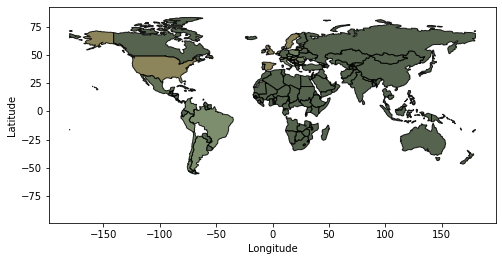

In [342]:
# Reference Material Used: https://towardsdatascience.com/kohonen-self-organizing-maps-a29040d688da

# Self-Organizing Map Algorithm
for m_iter in range(iterations):
    input_vec = df_scaled.sample()
    input_vec = input_vec.values.tolist()[0][1:]
    
    dist = [] #list of tuples ( (i,j), distance )

    for row in range(som_dim[0]):
        for col in range(som_dim[1]):
            curr_neuron = neurons[row][col]
            m_dist = math.dist(input_vec, curr_neuron)
            dist.append( ((row, col),m_dist))

    
    
    BMU_ij, dist = min(dist, key=lambda x: x[1])
    bmu_weights = neurons[BMU_ij[0]][BMU_ij[1]]
    curr_radius = decaying_radius(time_const, m_iter, radius)
    curr_learning_rate = decaying_learning_rate(iterations, m_iter, learning_rate)

    #Updating neighbours
    

    for row in range(som_dim[0]):
        for col in range(som_dim[1]):

            curr_neuron = neurons[row][col]
            curr_neuron_dist = math.dist(bmu_weights, curr_neuron)
            
            if (check_neighbour(BMU_ij, row, col, curr_radius)): 
                curr_neuron_infl = neighbour_influence(radius, curr_neuron_dist)
                for w in range(data_dimensions):
                    updated_w = curr_learning_rate * \
                    curr_neuron_infl * (bmu_weights[w] - curr_neuron[w])
                    curr_neuron[w] += updated_w


    # if m_iter % 1000 == 0:
    # #     print(neurons_in_radius)
    #     drawColorMap(neurons, m_iter)
    #     # print(neurons)
    #     # break

print("done")
# for row in range(som_dim[0]):
#         for col in range(som_dim[1]):
#             neurons[row][col].append([])
country_color = []
for index, row in df_scaled.iterrows():
    input_vec = row
    country = input_vec.values.tolist()[0]
    input_vec = input_vec.values.tolist()[1:]
    dist = []
    for row in range(som_dim[0]):
        for col in range(som_dim[1]):
            curr_neuron = neurons[row][col]
            m_dist = math.dist(input_vec, curr_neuron[:data_dimensions])
            # m_dist = manhattan_dist(input_vec, curr_neuron)
            dist.append( ((row, col),m_dist))
    
    BMU_ij, dist = min(dist, key=lambda x: x[1])
    red, green, blue = neurons[BMU_ij[0]][BMU_ij[1]]
    red, green, blue = hex(int(red*255))[2:], hex(int(green*255))[2:], hex(int(blue*255))[2:]
    red, green, blue = ("0"*abs(len(red)-2)) + red, ("0"*abs(len(green)-2)) + green, ("0"*abs(len(blue)-2)) + blue 
    country_color.append((pycountry.countries.get(name=country).alpha_3, f"#{red}{green}{blue}"))
# drawColorMap(neurons, iterations)

    
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# print(country_color[0])
def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.iso_a3 == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    if namigm != []:
        namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
        axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2 ))

# plot the whole world
#ax2 = world.plot( figsize=(8,4), edgecolor=u'gray', cmap='Set2' )

# or plot Africa continent
ax2 = world.plot(figsize=(8,8), edgecolor=u'white', color=u"white")

# then plot some countries on top
# plotCountryPatch(ax2, 'Namibia', 'red')
# plotCountryPatch(ax2, 'Libya', 'green')
# plotCountryPatch(ax2, 'Pakistan', '#000000')

for country, color in country_color:
    # print(country)
    plotCountryPatch(ax2, country, color)
    # break


# the place to plot additional vector data (points, lines)

plt.ylabel('Latitude')
plt.xlabel('Longitude')

#ax2.axis('scaled')
plt.show()